# EDA

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'svg' # plots look nicer in svg
%matplotlib inline
sns.set()
pd.options.display.max_colwidth = 160

## Load data

In [4]:
train = pd.read_csv('../Data/train.csv')
test  = pd.read_csv('../Data/test.csv')

In [5]:
train.shape, test.shape

((19579, 3), (8392, 2))

In [6]:
train.head(2)

,id,text,author
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set ...",EAP
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL


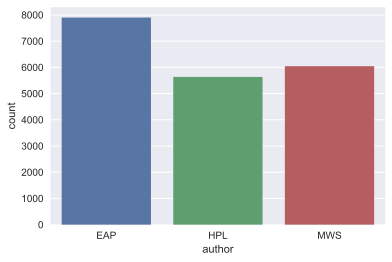

In [7]:
sns.countplot(x=train.author);

We see that classes are balanced

# Preprocessing

In [23]:
import spacy
import nltk

In [24]:
nlp = spacy.load('en')

In [25]:
# add custom stop words
nlp.vocab["'s"].is_stop = True
for word in spacy.lang.en.STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

Define function to replace named entities in text

In [26]:
def replace_ents(doc):
    prefix = 'ent__'
    text = str(doc.doc)
    for ent in doc.ents:
        text = text.replace(ent.orth_, prefix + ent.label_)
    return text

Define func to preprocess text data. Here I am doing the following:
- Parsing text with spaCy
- Handcrafting new features identifying number of:
    - characters
    - words
    - punctuation characters
    - named entities
    - noun chunks
    - unique words
    - stop words
    - characters by word
- Replace named entities with tags like 'ent_ORG'
- Lemmatize
- Delete stopwords

I leave 3 different versions of text in order to try which fits best with CV.

In [27]:
def preprocess(df):
    print('Started parsing...')
    doc = df.text.apply(nlp)
    print('Text parsed')
    
    df['n_char']   = df.text.apply(len)
    df['n_words']  = doc.apply(lambda x: len([t for t in x if not t.is_punct]))
    df['n_punct']  = doc.apply(lambda x: len([t for t in x if t.is_punct]))
    df['n_ents']   = doc.apply(lambda x: len(x.ents))
    df['n_chunks'] = doc.apply(lambda x: len(list(x.noun_chunks)))
    df['n_unique_words'] = doc.apply(lambda x: len(set([t.lower_ for t in x if not t.is_punct])))
    df['n_stop_words']   = doc.apply(lambda x: len([t for t in x if t.is_stop]))
    df['char_by_word']   = doc.apply(lambda x: np.mean([len(t.orth_) for t in x if not t.is_punct]))
    print('Features created')
    
    df['text_ent_repl'] = doc.apply(replace_ents)
    print('Entities replaced')
    
    clean_and_lemmatize = lambda x: ' '.join([t.lemma_ for t in x if not t.is_punct and not t.is_stop])
    df['text_cleaned'] = doc.apply(clean_and_lemmatize)
    print('Text cleaned')

In [28]:
%%time
preprocess(train)

Started parsing...
Text parsed
Features created
Entities replaced
Text cleaned
CPU times: user 4min 12s, sys: 10.5 s, total: 4min 22s
Wall time: 3min 11s


In [29]:
%%time
preprocess(test)

Started parsing...
Text parsed
Features created
Entities replaced
Text cleaned
CPU times: user 1min 45s, sys: 4.06 s, total: 1min 49s
Wall time: 1min 18s


## Visulizations

Split train by authors to make distinct visualizations

In [30]:
eap = train.loc[train.author == 'EAP']
hpl = train.loc[train.author == 'HPL']
mws = train.loc[train.author == 'MWS']

eap_t = eap.text_cleaned
hpl_t = hpl.text_cleaned
mws_t = mws.text_cleaned

### Plot frequncies

In [31]:
fd = nltk.FreqDist([y for x in train.text_cleaned.str.split() for y in x])

fd_eap = nltk.FreqDist([y for x in eap_t.str.split() for y in x])
fd_hpl = nltk.FreqDist([y for x in hpl_t.str.split() for y in x])
fd_mws = nltk.FreqDist([y for x in mws_t.str.split() for y in x])

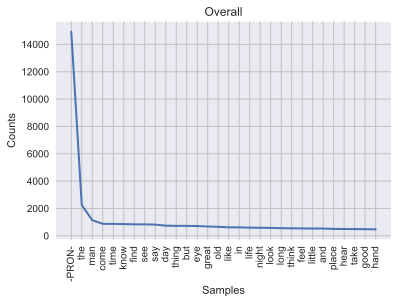

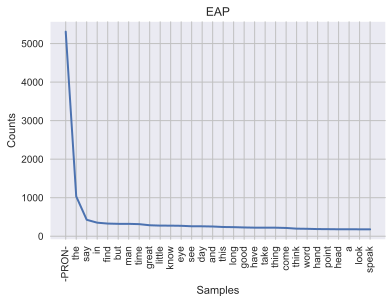

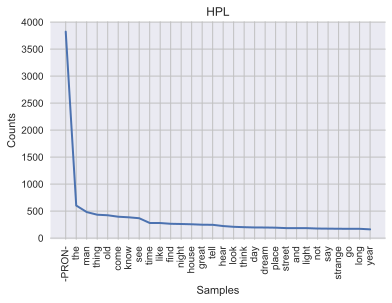

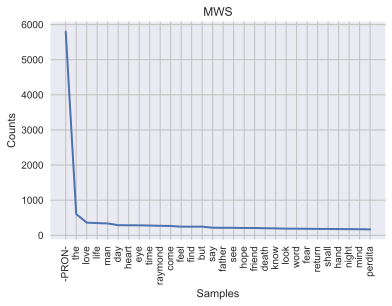

In [32]:
fd.plot(30, title='Overall')
fd_eap.plot(30, title='EAP')
fd_hpl.plot(30, title='HPL')
fd_mws.plot(30, title='MWS')

We see that top frequent words differ for the most part depending on the author, though they have some common words like 'man', 'see'.

### Word Clouds

In [33]:
from wordcloud import WordCloud
sns.set_style({'axes.grid' : False})

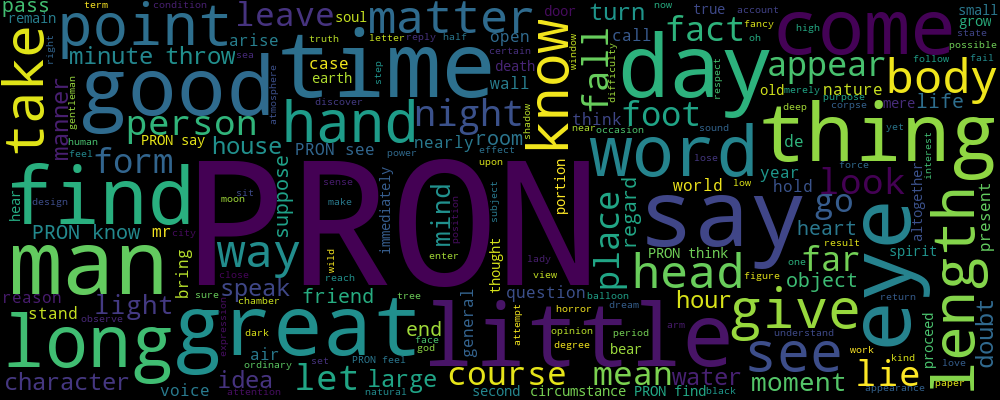

In [34]:
WordCloud(min_font_size=8, width=1000, height=400).generate(' '.join(eap_t)).to_image()

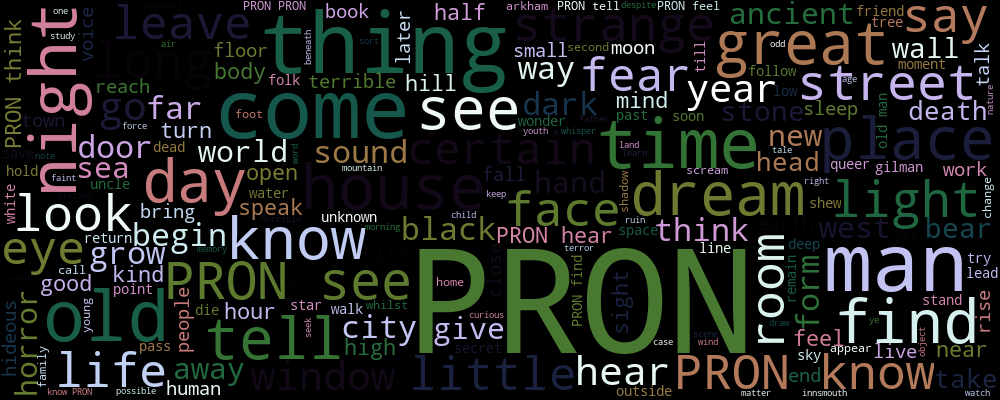

In [35]:
WordCloud(min_font_size=8, width=1000, height=400, colormap='cubehelix_r').generate(' '.join(hpl_t)).to_image()

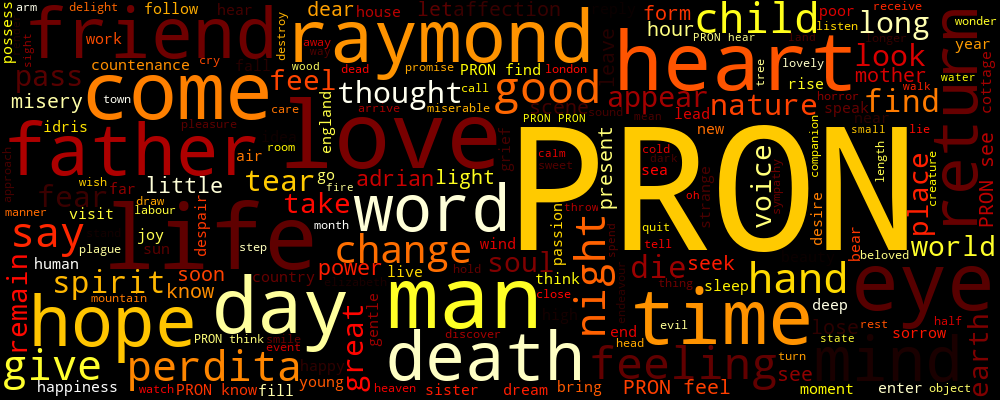

In [36]:
WordCloud(min_font_size=8, width=1000, height=400, colormap='hot').generate(' '.join(mws_t)).to_image()

### Meta-features distributions

In [37]:
sns.set()

In [38]:
def drop_outliers(s):
    med = s.mean()
    std = s.std()
    return s[(med - 3*std <= s) & (s <= med + 3*std)]

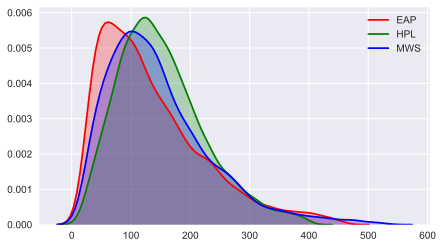

In [39]:
f, ax = plt.subplots(figsize=(7,4))
sns.kdeplot(drop_outliers(eap.n_char), shade=True, color="r");
sns.kdeplot(drop_outliers(hpl.n_char), shade=True, color="g");
sns.kdeplot(drop_outliers(mws.n_char), shade=True, color="b");
ax.legend(labels=['EAP', 'HPL', 'MWS']);

We see that EAP's texts are a little bit shorter on average while HPL's are longer

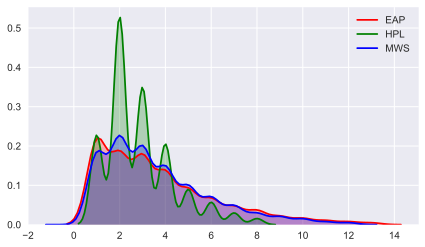

In [40]:
f, ax = plt.subplots(figsize=(7,4))
sns.kdeplot(drop_outliers(eap.n_punct), shade=True, color="r");
sns.kdeplot(drop_outliers(hpl.n_punct), shade=True, color="g");
sns.kdeplot(drop_outliers(mws.n_punct), shade=True, color="b");
ax.legend(labels=['EAP', 'HPL', 'MWS']);

Here we see some difference in distribution between HPL and others

# Models

In [41]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline

In [42]:
y = train.author

## Only text

### CountVect + untouched text

In [43]:
vectorizer = CountVectorizer(
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2), stop_words='english'
)
X = vectorizer.fit_transform(train.text)

In [44]:
%%time
scores = cross_val_score(LogisticRegression(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.502 +- 0.024
CPU times: user 234 ms, sys: 46.1 ms, total: 280 ms
Wall time: 16min 58s


In [45]:
%%time
scores = cross_val_score(MultinomialNB(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.443 +- 0.034
CPU times: user 252 ms, sys: 50.6 ms, total: 302 ms
Wall time: 1.26 s


0.443 - Nice performance with just NB!

### CountVect + cleaned text

In [46]:
vectorizer = CountVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(train.text_cleaned)

In [47]:
%%time
scores = cross_val_score(LogisticRegression(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.496 +- 0.029
CPU times: user 247 ms, sys: 49.6 ms, total: 297 ms
Wall time: 11.5 s


In [48]:
%%time
scores = cross_val_score(MultinomialNB(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.483 +- 0.047
CPU times: user 223 ms, sys: 46.2 ms, total: 269 ms
Wall time: 630 ms


### CountVect + replaced entities text

In [49]:
vectorizer = CountVectorizer(token_pattern=r'\w{1,}', stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(train.text_ent_repl)

In [50]:
%%time
scores = cross_val_score(LogisticRegression(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.553 +- 0.022
CPU times: user 239 ms, sys: 52.5 ms, total: 291 ms
Wall time: 11.8 s


In [51]:
%%time
scores = cross_val_score(MultinomialNB(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.518 +- 0.034
CPU times: user 214 ms, sys: 43.9 ms, total: 258 ms
Wall time: 632 ms


Seems like replacing named entities doesn't help

### TF-IDF + cleaned text

In [52]:
vectorizer = TfidfVectorizer(
    token_pattern=r'\w{1,}', ngram_range=(1, 1), 
    use_idf=True, smooth_idf=True, sublinear_tf=True,
)
X = vectorizer.fit_transform(train.text_cleaned)

In [53]:
%%time
scores = cross_val_score(LogisticRegression(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.603 +- 0.015
CPU times: user 187 ms, sys: 48.7 ms, total: 236 ms
Wall time: 1.54 s


In [54]:
%%time
scores = cross_val_score(MultinomialNB(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.584 +- 0.014
CPU times: user 177 ms, sys: 47.9 ms, total: 225 ms
Wall time: 517 ms


tfidf performs worse than simple count vect

## Only meta-features

In [58]:
import xgboost as xgb
import lightgbm as lgb

In [59]:
drop = ['id', 'text', 'text_cleaned', 'text_ent_repl']

In [60]:
X_meta = train.drop(drop + ['author'], axis=1)

In [61]:
%%time
lgbc = lgb.LGBMClassifier(objective='multiclass', n_estimators=100)
scores = cross_val_score(lgbc, X_meta, y, cv=4, n_jobs=1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

/Users/pcorr/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/Users/pcorr/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/Users/pcorr/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/Users/pcorr/anaconda3/envs/py36/l

LogLoss: 0.961 +- 0.005
CPU times: user 4.2 s, sys: 4.51 s, total: 8.7 s
Wall time: 5.53 s


In [62]:
%%time
xgbc = xgb.XGBClassifier(objective='multi:softprob', n_estimators=200)
scores = cross_val_score(xgbc, X_meta, y, cv=4, n_jobs=4, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.959 +- 0.005
CPU times: user 122 ms, sys: 37 ms, total: 159 ms
Wall time: 3.52 s


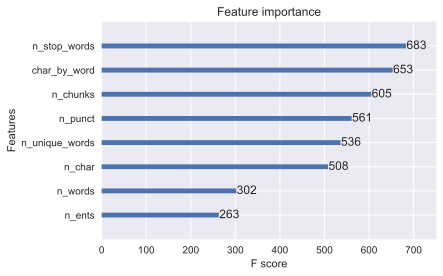

In [63]:
xgbc.fit(X_meta, y);
xgb.plot_importance(xgbc);

## Stack 'em

In [64]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

In [65]:
def add_prob_features(vectorizer, col, model, prefix, cv=5):
    vectorizer.fit(train[col].append(test[col]))
    X = vectorizer.transform(train[col])
    X_test = vectorizer.transform(test[col])
    
    cv_scores = []
    pred_test = 0
    pred_train = np.zeros([train.shape[0], 3])
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=123)
    
    print('CV started')
    for train_index, dev_index in kf.split(X, y):
        X_train, X_dev = X[train_index], X[dev_index]
        y_train, y_dev = y[train_index], y[dev_index]
        
        model.fit(X_train, y_train)
        pred_dev   = model.predict_proba(X_dev)
        pred_test += model.predict_proba(X_test)
    
        pred_train[dev_index, :] = pred_dev
        cv_scores.append(metrics.log_loss(y_dev, pred_dev))
        print('.', end='')
        
    print('')
    print("Mean CV LogLoss: %.3f" % (np.mean(cv_scores)))
    pred_test /= cv

    train[prefix+'eap'] = pred_train[:, 0]
    train[prefix+'hpl'] = pred_train[:, 1]
    train[prefix+'mws'] = pred_train[:, 2]
    
    test[prefix+'eap'] = pred_test[:, 0]
    test[prefix+'hpl'] = pred_test[:, 1]
    test[prefix+'mws'] = pred_test[:, 2]

In [66]:
vectorizer = CountVectorizer(
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2), stop_words='english'
)
add_prob_features(vectorizer, 'text', MultinomialNB(), 'nb_ctv_', cv=40)

CV started
........................................
Mean CV LogLoss: 0.433


In [67]:
vectorizer = TfidfVectorizer(
    token_pattern=r'\w{1,}', ngram_range=(1, 1), 
    use_idf=True, smooth_idf=True, sublinear_tf=True,
)
add_prob_features(vectorizer, 'text_cleaned', MultinomialNB(), 'nb_tfv_', cv=40)

CV started
........................................
Mean CV LogLoss: 0.576


In [68]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 5), analyzer='char'
)
add_prob_features(vectorizer, 'text', MultinomialNB(), 'nb_char_', cv=40)

CV started
........................................
Mean CV LogLoss: 0.732


In [69]:
vectorizer = CountVectorizer(
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2), stop_words='english'
)
add_prob_features(vectorizer, 'text_ent_repl', MultinomialNB(), 'nb_ent_', cv=40)

CV started
........................................
Mean CV LogLoss: 0.510


In [70]:
X = train.drop(drop + ['author'], axis=1)

In [71]:
%%time
lgbc = lgb.LGBMClassifier(objective='multiclass', n_estimators=150, num_leaves=10)
scores = cross_val_score(lgbc, X, y, cv=4, n_jobs=1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

/Users/pcorr/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/Users/pcorr/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/Users/pcorr/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/Users/pcorr/anaconda3/envs/py36/l

LogLoss: 0.345 +- 0.015
CPU times: user 5.32 s, sys: 2.12 s, total: 7.44 s
Wall time: 3.83 s


In [72]:
%%time
xgbc = xgb.XGBClassifier(objective='multi:softprob', n_estimators=150)
scores = cross_val_score(xgbc, X, y, cv=4, n_jobs=1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.344 +- 0.014
CPU times: user 23.1 s, sys: 1.19 s, total: 24.3 s
Wall time: 8.76 s


In [73]:
%%time
xgbc.fit(X, y);

CPU times: user 7.24 s, sys: 302 ms, total: 7.55 s
Wall time: 2.84 s


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=150, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

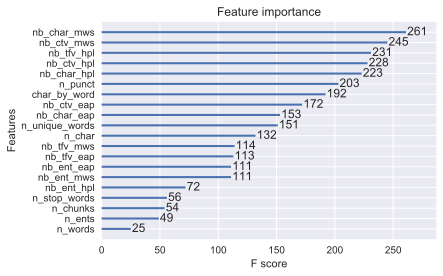

In [74]:
xgb.plot_importance(xgbc);

In [75]:
def sub(est, name='sub.csv'):
    sub = pd.DataFrame(est.predict_proba(test.drop(drop, axis=1)), columns=['EAP', 'HPL', 'MWS'])
    sub.insert(0, 'id', test.id)
    sub.to_csv(name, index=False)

In [76]:
from sklearn import model_selection

In [77]:
clf = xgb.XGBClassifier(objective = 'multi:softprob', nthread=1)

parameters = {
    'n_estimators': [150],
    'max_depth': [3],
    'subsample': [0.65],
    'colsample_bytree': [0.95],
    'min_child_weight': [1],
}

clf = model_selection.GridSearchCV(clf, parameters, n_jobs=4, verbose=1, scoring='neg_log_loss', refit=True)  

In [78]:
clf.fit(X, y);

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    5.6s finished


In [79]:
-clf.best_score_

0.34300154006076788

In [80]:
sub(clf.best_estimator_)

In [97]:
train.columns

Index(['id', 'text', 'author', 'n_char', 'n_words', 'n_punct', 'n_ents',
       'n_chunks', 'n_unique_words', 'n_stop_words', 'char_by_word',
       'text_ent_repl', 'text_cleaned', 'nb_ctv_eap', 'nb_ctv_hpl',
       'nb_ctv_mws', 'nb_tfv_eap', 'nb_tfv_hpl', 'nb_tfv_mws', 'nb_char_eap',
       'nb_char_hpl', 'nb_char_mws', 'nb_ent_eap', 'nb_ent_hpl', 'nb_ent_mws'],
      dtype='object')

In [100]:
drop

['id', 'text', 'text_cleaned', 'text_ent_repl']

In [99]:
train.drop(drop + ['author'], axis=1).columns

Index(['n_char', 'n_words', 'n_punct', 'n_ents', 'n_chunks', 'n_unique_words',
       'n_stop_words', 'char_by_word', 'nb_ctv_eap', 'nb_ctv_hpl',
       'nb_ctv_mws', 'nb_tfv_eap', 'nb_tfv_hpl', 'nb_tfv_mws', 'nb_char_eap',
       'nb_char_hpl', 'nb_char_mws', 'nb_ent_eap', 'nb_ent_hpl', 'nb_ent_mws'],
      dtype='object')

In [101]:
test.columns

Index(['id', 'text', 'n_char', 'n_words', 'n_punct', 'n_ents', 'n_chunks',
       'n_unique_words', 'n_stop_words', 'char_by_word', 'text_ent_repl',
       'text_cleaned', 'nb_ctv_eap', 'nb_ctv_hpl', 'nb_ctv_mws', 'nb_tfv_eap',
       'nb_tfv_hpl', 'nb_tfv_mws', 'nb_char_eap', 'nb_char_hpl', 'nb_char_mws',
       'nb_ent_eap', 'nb_ent_hpl', 'nb_ent_mws'],
      dtype='object')

In [104]:
train.drop(drop + ['author'], axis=1).shape

(19579, 20)

In [102]:
test_set = test.drop(drop, axis=1)

In [107]:
test_set

,n_char,n_words,n_punct,n_ents,n_chunks,n_unique_words,n_stop_words,char_by_word,nb_ctv_eap,nb_ctv_hpl,nb_ctv_mws,nb_tfv_eap,nb_tfv_hpl,nb_tfv_mws,nb_char_eap,nb_char_hpl,nb_char_mws,nb_ent_eap,nb_ent_hpl,nb_ent_mws
0,110,19,3,1,5,19,8,4.684211,1.545984e-02,3.312183e-04,9.842089e-01,0.230652,0.098221,0.671127,0.232347,0.012655,0.754998,5.823803e-02,4.312031e-04,9.413308e-01
1,330,62,7,1,18,49,34,4.225806,9.999945e-01,3.446735e-06,2.087760e-06,0.700198,0.136107,0.163695,0.983572,0.005594,0.010834,9.999484e-01,3.900615e-05,1.257352e-05
2,189,33,3,1,8,29,16,4.666667,2.215611e-01,7.783635e-01,7.545684e-05,0.503695,0.428797,0.067507,0.469981,0.509879,0.020140,1.628833e-01,8.371049e-01,1.173201e-05
3,223,41,5,1,8,34,22,4.341463,8.661980e-01,1.338018e-01,2.889649e-07,0.663662,0.296392,0.039946,0.844240,0.137173,0.018588,9.387625e-01,6.123734e-02,1.704583e-07
4,53,11,1,0,3,11,6,3.818182,9.732482e-01,2.003748e-02,6.714317e-03,0.802988,0.117125,0.079887,0.814009,0.049216,0.136775,9.721410e-01,2.100861e-02,6.850412e-03
5,202,32,8,1,6,26,14,5.093750,9.538263e-01,4.603862e-02,1.350576e-04,0.635524,0.278847,0.085629,0.958408,0.009951,0.031642,9.628292e-01,3.681220e-02,3.586074e-04
6,68,13,2,0,2,11,9,4.153846,6.870980e-01,2.845756e-01,2.832636e-02,0.464174,0.474286,0.061539,0.952083,0.029854,0.018063,6.831698e-01,2.888510e-01,2.797925e-02
7,155,30,3,0,9,23,16,4.100000,4.091325e-04,4.186284e-02,9.577280e-01,0.122817,0.171688,0.705495,0.190647,0.138398,0.670955,4.079373e-04,4.165399e-02,9.579381e-01
8,172,28,5,1,7,22,15,5.000000,9.995290e-01,4.707740e-04,2.722910e-07,0.878366,0.095923,0.025711,0.996014,0.002152,0.001834,9.965947e-01,3.402364e-03,2.891802e-06
9,42,8,2,0,1,8,4,4.125000,8.133049e-01,6.797533e-02,1.187198e-01,0.607174,0.180903,0.211923,0.926659,0.042538,0.030803,8.129888e-01,7.221005e-02,1.148012e-01


In [108]:
pred = clf.predict_proba(test_set)

In [109]:
pred

array([[ 0.01762503,  0.00270423,  0.97967076],
       [ 0.99618465,  0.00152873,  0.00228662],
       [ 0.0417346 ,  0.95630956,  0.00195586],
       ..., 
       [ 0.98698491,  0.00923016,  0.00378488],
       [ 0.04657585,  0.00181697,  0.95160723],
       [ 0.06907161,  0.92952508,  0.00140326]], dtype=float32)

In [111]:
authors = ['MWS','EAP','HPL']

In [113]:
pred_df = pd.DataFrame(pred, columns=authors)

In [117]:
test.columns

Index(['id', 'text', 'n_char', 'n_words', 'n_punct', 'n_ents', 'n_chunks',
       'n_unique_words', 'n_stop_words', 'char_by_word', 'text_ent_repl',
       'text_cleaned', 'nb_ctv_eap', 'nb_ctv_hpl', 'nb_ctv_mws', 'nb_tfv_eap',
       'nb_tfv_hpl', 'nb_tfv_mws', 'nb_char_eap', 'nb_char_hpl', 'nb_char_mws',
       'nb_ent_eap', 'nb_ent_hpl', 'nb_ent_mws'],
      dtype='object')

In [121]:
pred_df['id'] = test['id']
pred_df = pred_df[['id','EAP','HPL','MWS']]

In [126]:
pred_df.to_csv('../predictions/xgb3_pred.csv', index=False)